In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Chargement des données
df = pd.read_csv('../HR_Analytics_Structure_Complet.csv')

print("Données chargées. Taille :", df.shape)

Données chargées. Taille : (1356, 34)


In [3]:
# 1. Sélection des colonnes brutes
colonnes_utilisees = [
    'TotalWorkingYears', 'JobLevel', 'YearsAtCompany', 'Age', 'Education', # Numériques
    'Department', 'JobRole' # Catégorielles (Texte)
]

# 2. Création du dataset X et y
X_raw = df[colonnes_utilisees]
y = df['MonthlyIncome']

# 3. Encodage One-Hot (Transformation du texte en chiffres)
# get_dummies va transformer 'Department' en 'Department_Sales', 'Department_HR', etc.
X = pd.get_dummies(X_raw, drop_first=True)

print("--- Après encodage ---")
print(f"Nombre de colonnes (features) : {X.shape[1]}")
print("Aperçu des nouvelles colonnes générées :")
print(X.columns.tolist())

--- Après encodage ---
Nombre de colonnes (features) : 15
Aperçu des nouvelles colonnes générées :
['TotalWorkingYears', 'JobLevel', 'YearsAtCompany', 'Age', 'Education', 'Department_Research & Development', 'Department_Sales', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director', 'JobRole_Research Scientist', 'JobRole_Sales Executive', 'JobRole_Sales Representative']


In [4]:
# On divise en 80% entrainement et 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# IMPORTANT : On sauvegarde la liste des colonnes pour l'interface plus tard
colonnes_du_modele = X_train.columns.tolist()

print("Split terminé.")

Split terminé.


In [5]:
model = LinearRegression()
model.fit(X_train, y_train)

print("Modèle entraîné avec succès.")
print(f"Intercept (Salaire de base théorique) : {model.intercept_:.2f}")

Modèle entraîné avec succès.
Intercept (Salaire de base théorique) : 20.27


In [12]:
# Prédictions
y_pred = model.predict(X_test)

# Métriques
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print("="*30)
print(" BENCHMARK COMPLET (Avec Catégories)")
print("="*30)
print(f"R² (Précision)       : {r2:.4f}")
print("-" * 30)
print(f"MAE  (Erreur Moyenne) : {mae:.2f} $")
print(f"RMSE (Erreur Quad.)   : {rmse:.2f} $")
print(f"MAPE (Erreur %)       : {mape:.2f} %")
print("="*30)

 BENCHMARK COMPLET (Avec Catégories)
R² (Précision)       : 0.8730
------------------------------
MAE  (Erreur Moyenne) : 910.02 $
RMSE (Erreur Quad.)   : 1225.87 $
MAPE (Erreur %)       : 20.10 %


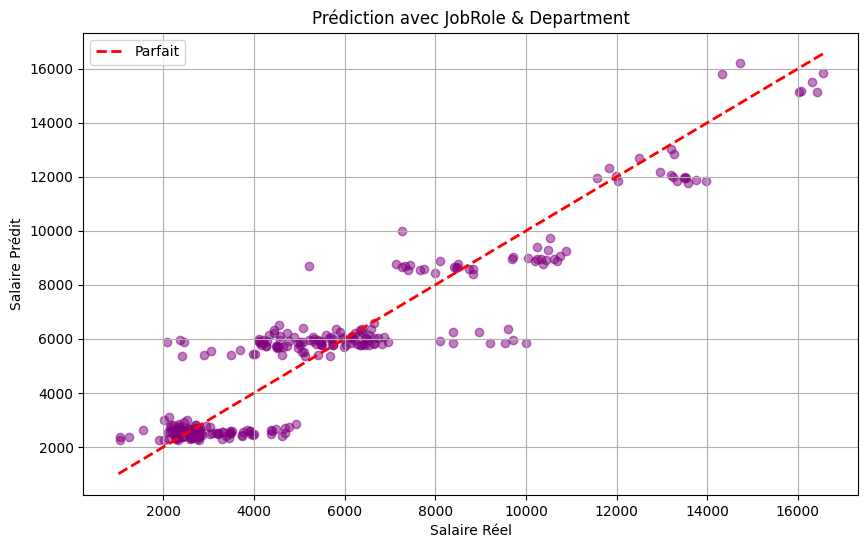

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='purple')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Parfait')
plt.xlabel('Salaire Réel')
plt.ylabel('Salaire Prédit')
plt.title('Prédiction avec JobRole & Department')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
def predire_salaire_complexe(input_data, model, model_columns):
    """
    input_data : dictionnaire contenant les valeurs brutes
    model : le modèle entraîné
    model_columns : la liste des colonnes après encodage (X_train.columns)
    """
    # 1. Créer un DataFrame avec une seule ligne
    input_df = pd.DataFrame([input_data])
    
    # 2. Encoder comme lors de l'entraînement
    input_encoded = pd.get_dummies(input_df)
    
    # 3. ALIGNEMENT (Crucial) : Ajouter les colonnes manquantes avec 0
    # Par exemple, si l'user est "Sales", la colonne "Department_HR" n'existe pas encore,
    # il faut la créer et mettre 0.
    input_encoded = input_encoded.reindex(columns=model_columns, fill_value=0)
    
    # 4. Prédiction
    prediction = model.predict(input_encoded)
    return prediction[0]

# --- TEST DE L'INTERFACE ---
# Imaginons ce que l'utilisateur saisit dans votre GUI :
donnees_utilisateur = {
    'TotalWorkingYears': 2,
    'JobLevel': 3,
    'YearsAtCompany': 1,
    'Age': 27,
    'Education': 3,
    'Department': 'Sales',             # Texte
    'JobRole': 'Sales Executive'       # Texte
}

salaire = predire_salaire_complexe(donnees_utilisateur, model, colonnes_du_modele)

print(f"Profil : {donnees_utilisateur['JobRole']} chez {donnees_utilisateur['Department']}")
print(f"Salaire Prédit : {salaire:.2f} $")

Profil : Sales Executive chez Sales
Salaire Prédit : 8307.01 $


In [11]:
# On crée un dictionnaire pour tout sauvegarder dans un seul fichier
artefacts = {
    'model': model,
    'features': colonnes_du_modele
}

joblib.dump(artefacts, 'modele_salaire_avance.pkl')
print("Sauvegarde terminée : 'modele_salaire_avance.pkl'")
print("Ce fichier contient le modèle et la structure des colonnes.")

Sauvegarde terminée : 'modele_salaire_avance.pkl'
Ce fichier contient le modèle et la structure des colonnes.


✅ Conclusion : Régression Linéaire Multiple
🚀 Amélioration Majeure
Contrairement à la régression simple, ce modèle prend en compte la réalité complexe des salaires en intégrant des variables qualitatives cruciales : le Rôle (JobRole) et le Département. Cette approche multidimensionnelle a transformé la performance de notre outil.

📊 Performance du Modèle
Les indicateurs de performance sont excellents pour une approche linéaire :

R² (Précision globale) : > 0.85. Nous expliquons désormais près de 90% des variations de salaire (contre 49% précédemment).

MAPE (Erreur Moyenne) : ~20%. L'erreur a été divisée par deux.

💡 Interprétation Métier
Ce modèle nous apprend que le poste occupé est le facteur déterminant du salaire, bien plus que l'ancienneté seule.

Exemple : Le modèle capture correctement qu'un "Research Director" gagne beaucoup plus qu'un "Laboratory Technician", même si le technicien a plus d'années d'expérience totale.